# ISP-GIN Comprehensive Final Evaluation: Hypothesis Verdict & Disconfirmation Analysis

**Evaluation of complex-valued interference-based structural probing (ISP-GIN) vs. real-valued topological augmentation (RealGIN-Aug).**

This notebook synthesizes experiments from iterations 2-3 to produce:
1. **McNemar's test** — statistical comparison of ISP-GIN vs RealGIN-Aug on 55 graph pairs
2. **Per-dataset breakdown** — rates with confidence intervals across 4 BREC subsets
3. **CSL failure analysis** — mathematical root cause on k-regular graphs
4. **Feature/initialization importance** — ranking 7 init strategies from iter2's 140-config sweep
5. **Literature positioning** — comparison against published BREC baselines
6. **Hypothesis verdict** — structured judgment on 5 original assumptions

**Key finding**: ISP-GIN's complex-valued interference mechanism adds **no expressiveness** beyond real-valued topological augmentation. The hypothesis is **DISCONFIRMED**.

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# statsmodels — NOT pre-installed on Colab
_pip('statsmodels==0.14.6')

# Core packages (pre-installed on Colab, install locally to match Colab env)
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'scipy==1.16.3', 'matplotlib==3.10.0')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [2]:
import json
import math
import time

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from statsmodels.stats.contingency_tables import mcnemar

## Data Loading

Load evaluation results from GitHub (with local fallback). The data contains 55 graph pairs across 4 BREC subsets, with predictions from 5 methods (ISP-GIN, RealGIN-Aug, WL baseline, ISP-NoMP magnitude, ISP-NoMP phase).

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-1a90b0-interference-based-structural-probing-br/main/evaluation_iter4_isp_gin_compreh/demo/mini_demo_data.json"
import json, os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {sum(len(ds['examples']) for ds in data['datasets'])} examples across {len(data['datasets'])} datasets")
print(f"Datasets: {[ds['dataset'] for ds in data['datasets']]}")
print(f"Metadata sections: {len(data['metadata']['sections'])}")

Loaded 55 examples across 4 datasets
Datasets: ['brec_basic', 'brec_regular', 'brec_cfi', 'csl']
Metadata sections: 6


## Configuration

Dataset sizes, published baselines, and init strategy parameters. These match the original evaluation script.

In [5]:
# ---------------------------------------------------------------------------
# Config: dataset sizes and parameters
# ---------------------------------------------------------------------------
DATASET_SIZES = {
    "brec_basic": 10,
    "brec_regular": 15,
    "brec_cfi": 10,
    "csl": 20,
}
TOTAL_PAIRS = 55

# Maximum examples per dataset (None = use all)
MAX_EXAMPLES_PER_DATASET = None  # Set to e.g. 3 for quick testing

# BREC published baselines (Table 2 from BREC NeurIPS 2023 paper, 400-pair benchmark)
BREC_PUBLISHED = {
    "i2gnn": {"total": 281, "out_of": 400, "basic": 60, "regular": 100, "extension": 100, "cfi": 21},
    "gsn": {"total": 254, "out_of": 400, "basic": 60, "regular": 99, "extension": 95, "cfi": 0},
    "kp_gnn": {"total": 275, "out_of": 400, "basic": 60, "regular": 106, "extension": 98, "cfi": 11},
    "gin_baseline": {"total": 0, "out_of": 400, "basic": 0, "regular": 0, "extension": 0, "cfi": 0},
}

# Init strategies from iter2's 140-config sweep
ITER2_INIT_STRATEGIES = [
    "degree", "random_walk_t2", "random_walk_t3",
    "wl_color_r3", "local_topology", "multihop_hash", "spectral",
]

# Golden ratio omega used for phase initialization
OMEGA_TEST = (1.0 + math.sqrt(5.0)) / 2.0

# Confidence interval significance level
ALPHA = 0.05

DATASET_ORDER = ["brec_basic", "brec_regular", "brec_cfi", "csl"]

## Helper Functions

Statistical utilities: Clopper-Pearson exact confidence intervals, Cohen's h effect size, and data extraction.

In [6]:
def clopper_pearson_ci(
    k: int,
    n: int,
    alpha: float = 0.05,
) -> tuple:
    """Exact Clopper-Pearson 95% confidence interval for binomial proportion."""
    if n == 0:
        return (0.0, 1.0)
    if k == 0:
        lower = 0.0
    else:
        lower = scipy.stats.beta.ppf(alpha / 2, k, n - k + 1)
    if k == n:
        upper = 1.0
    else:
        upper = scipy.stats.beta.ppf(1 - alpha / 2, k + 1, n - k)
    return (float(lower), float(upper))


def cohens_h(p1: float, p2: float) -> float:
    """Cohen's h effect size for comparing two proportions.
    h = 2 * arcsin(sqrt(p1)) - 2 * arcsin(sqrt(p2))
    |h| > 0.8 is large effect.
    """
    return 2.0 * math.asin(math.sqrt(p1)) - 2.0 * math.asin(math.sqrt(p2))


def extract_examples_by_dataset(data: dict) -> dict:
    """Extract examples grouped by dataset name, with optional limit."""
    result = {}
    for ds_entry in data["datasets"]:
        ds_name = ds_entry["dataset"]
        examples = ds_entry["examples"]
        if MAX_EXAMPLES_PER_DATASET is not None:
            examples = examples[:MAX_EXAMPLES_PER_DATASET]
        result[ds_name] = examples
    return result

## Section 1: McNemar's Test — ISP-GIN vs RealGIN-Aug

Statistical comparison using McNemar's exact test on paired binary outcomes across all 55 graph pairs. Tests whether the two methods have significantly different error rates.

In [7]:
t0 = time.time()
iter3_by_dataset = extract_examples_by_dataset(data)

# Collect binary vectors: 1 = distinguished, 0 = not
isp_gin_vec = []
realgin_aug_vec = []
wl_vec = []
isp_nomp_mag_vec = []
isp_nomp_phase_vec = []

for ds_name in DATASET_ORDER:
    examples = iter3_by_dataset.get(ds_name, [])
    for ex in examples:
        isp_gin_vec.append(1 if ex.get("predict_isp_gin") == "distinguished" else 0)
        realgin_aug_vec.append(1 if ex.get("predict_realgin_aug") == "distinguished" else 0)
        wl_vec.append(1 if ex.get("predict_wl_baseline") == "distinguished" else 0)
        isp_nomp_mag_vec.append(1 if ex.get("predict_isp_nomp_mag") == "distinguished" else 0)
        isp_nomp_phase_vec.append(1 if ex.get("predict_isp_nomp_phase") == "distinguished" else 0)

isp_arr = np.array(isp_gin_vec)
real_arr = np.array(realgin_aug_vec)
n = len(isp_arr)

isp_count = int(isp_arr.sum())
real_count = int(real_arr.sum())
wl_count = int(np.array(wl_vec).sum())
nomp_mag_count = int(np.array(isp_nomp_mag_vec).sum())
nomp_phase_count = int(np.array(isp_nomp_phase_vec).sum())

isp_rate = isp_count / n
real_rate = real_count / n
gap = real_rate - isp_rate

# McNemar's 2x2 contingency table
a = int(np.sum((isp_arr == 1) & (real_arr == 1)))  # both distinguish
b = int(np.sum((isp_arr == 1) & (real_arr == 0)))  # ISP only
c = int(np.sum((isp_arr == 0) & (real_arr == 1)))  # Real only
d = int(np.sum((isp_arr == 0) & (real_arr == 0)))  # neither

table = np.array([[a, b], [c, d]])
mcnemar_result = mcnemar(table, exact=True)
mcnemar_pvalue = float(mcnemar_result.pvalue)
mcnemar_stat = float(mcnemar_result.statistic)

ci_isp = clopper_pearson_ci(isp_count, n, alpha=ALPHA)
ci_real = clopper_pearson_ci(real_count, n, alpha=ALPHA)
h = cohens_h(real_rate, isp_rate)

print("=" * 60)
print("SECTION 1: McNemar's Test — ISP-GIN vs RealGIN-Aug")
print("=" * 60)
print(f"Total pairs: {n}")
print(f"ISP-GIN:     {isp_count}/{n} = {isp_rate:.4f}  95% CI: [{ci_isp[0]:.4f}, {ci_isp[1]:.4f}]")
print(f"RealGIN-Aug: {real_count}/{n} = {real_rate:.4f}  95% CI: [{ci_real[0]:.4f}, {ci_real[1]:.4f}]")
print(f"Gap: {gap:.4f} ({gap*100:.1f}pp)")
print(f"WL baseline: {wl_count}/{n}")
print(f"ISP-NoMP magnitude: {nomp_mag_count}/{n}")
print(f"ISP-NoMP phase: {nomp_phase_count}/{n}")
print(f"\nContingency: a={a} (both), b={b} (ISP only), c={c} (Real only), d={d} (neither)")
print(f"McNemar statistic: {mcnemar_stat:.4f}")
print(f"McNemar p-value: {mcnemar_pvalue:.6f}")
print(f"Cohen's h: {h:.4f} (|h|>0.8 = large effect)")
print(f"Significant at alpha=0.05: {'YES' if mcnemar_pvalue < 0.05 else 'NO'}")

SECTION 1: McNemar's Test — ISP-GIN vs RealGIN-Aug
Total pairs: 55
ISP-GIN:     35/55 = 0.6364  95% CI: [0.4956, 0.7619]
RealGIN-Aug: 44/55 = 0.8000  95% CI: [0.6703, 0.8957]
Gap: 0.1636 (16.4pp)
WL baseline: 0/55
ISP-NoMP magnitude: 0/55
ISP-NoMP phase: 44/55

Contingency: a=35 (both), b=0 (ISP only), c=9 (Real only), d=11 (neither)
McNemar statistic: 0.0000
McNemar p-value: 0.003906
Cohen's h: 0.3673 (|h|>0.8 = large effect)
Significant at alpha=0.05: YES


## Section 2: Per-Dataset Breakdown

Per-dataset distinguishing rates with Clopper-Pearson CIs for all 5 methods. Reveals that ISP-GIN matches RealGIN-Aug on non-regular graphs but fails completely on CSL.

In [8]:
print("=" * 60)
print("SECTION 2: Per-Dataset Breakdown")
print("=" * 60)

per_dataset_results = {}

for ds_name in DATASET_ORDER:
    examples = iter3_by_dataset.get(ds_name, [])
    n_ds = len(examples)

    isp_c = sum(1 for ex in examples if ex.get("predict_isp_gin") == "distinguished")
    real_c = sum(1 for ex in examples if ex.get("predict_realgin_aug") == "distinguished")
    wl_c = sum(1 for ex in examples if ex.get("predict_wl_baseline") == "distinguished")
    nomp_mag_c = sum(1 for ex in examples if ex.get("predict_isp_nomp_mag") == "distinguished")
    nomp_phase_c = sum(1 for ex in examples if ex.get("predict_isp_nomp_phase") == "distinguished")

    isp_r = isp_c / n_ds if n_ds > 0 else 0.0
    real_r = real_c / n_ds if n_ds > 0 else 0.0
    ci_i = clopper_pearson_ci(isp_c, n_ds, alpha=ALPHA)
    ci_r = clopper_pearson_ci(real_c, n_ds, alpha=ALPHA)

    per_dataset_results[ds_name] = {
        "n": n_ds, "isp_count": isp_c, "real_count": real_c,
        "wl_count": wl_c, "nomp_mag_count": nomp_mag_c, "nomp_phase_count": nomp_phase_c,
        "isp_rate": isp_r, "real_rate": real_r,
        "wl_rate": wl_c / n_ds if n_ds else 0.0,
        "nomp_mag_rate": nomp_mag_c / n_ds if n_ds else 0.0,
        "nomp_phase_rate": nomp_phase_c / n_ds if n_ds else 0.0,
        "ci_isp": ci_i, "ci_real": ci_r,
    }

    print(f"\n--- {ds_name} ({n_ds} pairs) ---")
    print(f"  ISP-GIN:     {isp_c}/{n_ds} = {isp_r:.4f} CI=[{ci_i[0]:.4f}, {ci_i[1]:.4f}]")
    print(f"  RealGIN-Aug: {real_c}/{n_ds} = {real_r:.4f} CI=[{ci_r[0]:.4f}, {ci_r[1]:.4f}]")
    print(f"  WL baseline: {wl_c}/{n_ds}")
    print(f"  ISP-NoMP mag: {nomp_mag_c}/{n_ds}")
    print(f"  ISP-NoMP phase: {nomp_phase_c}/{n_ds}")

SECTION 2: Per-Dataset Breakdown

--- brec_basic (10 pairs) ---
  ISP-GIN:     10/10 = 1.0000 CI=[0.6915, 1.0000]
  RealGIN-Aug: 10/10 = 1.0000 CI=[0.6915, 1.0000]
  WL baseline: 0/10
  ISP-NoMP mag: 0/10
  ISP-NoMP phase: 10/10

--- brec_regular (15 pairs) ---
  ISP-GIN:     15/15 = 1.0000 CI=[0.7820, 1.0000]
  RealGIN-Aug: 15/15 = 1.0000 CI=[0.7820, 1.0000]
  WL baseline: 0/15
  ISP-NoMP mag: 0/15
  ISP-NoMP phase: 15/15

--- brec_cfi (10 pairs) ---
  ISP-GIN:     10/10 = 1.0000 CI=[0.6915, 1.0000]
  RealGIN-Aug: 10/10 = 1.0000 CI=[0.6915, 1.0000]
  WL baseline: 0/10
  ISP-NoMP mag: 0/10
  ISP-NoMP phase: 10/10

--- csl (20 pairs) ---
  ISP-GIN:     0/20 = 0.0000 CI=[0.0000, 0.1684]
  RealGIN-Aug: 9/20 = 0.4500 CI=[0.2306, 0.6847]
  WL baseline: 0/20
  ISP-NoMP mag: 0/20
  ISP-NoMP phase: 9/20


## Section 3: CSL Failure Mathematical Analysis

Root cause analysis of ISP-GIN's complete failure on CSL (Circular Skip Link) graphs. On k-regular graphs, degree-based phase initialization assigns identical phases to all nodes, making the complex interference mechanism degenerate to 1-WL.

In [9]:
print("=" * 60)
print("SECTION 3: CSL Failure Mathematical Analysis")
print("=" * 60)

csl_examples = iter3_by_dataset.get("csl", [])
csl_isp_count = sum(1 for ex in csl_examples if ex.get("predict_isp_gin") == "distinguished")
csl_real_count = sum(1 for ex in csl_examples if ex.get("predict_realgin_aug") == "distinguished")

print(f"CSL ISP-GIN distinguished: {csl_isp_count}/20")
print(f"CSL RealGIN-Aug distinguished: {csl_real_count}/20")

# Analyze degree structure of CSL graphs from the input data
degree_variances = []
all_degrees_per_graph = []

for ex in csl_examples:
    input_data = json.loads(ex["input"])
    for graph_key in ["graph_a", "graph_b"]:
        g = input_data[graph_key]
        n_nodes = g["num_nodes"]
        edge_list = g["edge_list"]

        # Compute degrees
        deg = [0] * n_nodes
        for u, v in edge_list:
            deg[u] += 1
            deg[v] += 1

        deg_arr = np.array(deg, dtype=np.float64)
        degree_variances.append(float(np.var(deg_arr)))
        all_degrees_per_graph.append(deg_arr)

avg_degree_variance = float(np.mean(degree_variances))
max_degree_variance = float(np.max(degree_variances))

print(f"\nCSL degree variance (avg): {avg_degree_variance:.6f}")
print(f"CSL degree variance (max): {max_degree_variance:.6f}")

# Phase uniformity: z_v = exp(i * omega * deg(v)). All deg(v) = k => all phases identical.
phase_stds = []
for deg_arr in all_degrees_per_graph:
    phases = np.angle(np.exp(1j * OMEGA_TEST * deg_arr))
    phase_stds.append(float(np.std(phases)))

avg_phase_std = float(np.mean(phase_stds))
print(f"CSL phase uniformity (avg std of phases): {avg_phase_std:.10f}")

csl_results = {
    "csl_isp_distinguished": csl_isp_count,
    "csl_real_distinguished": csl_real_count,
    "csl_total": 20,
    "avg_degree_variance": avg_degree_variance,
    "avg_phase_uniformity_std": avg_phase_std,
    "n_graphs_analyzed": len(all_degrees_per_graph),
}

print(f"\nMathematical explanation:")
print(f"  On k-regular graphs (CSL: k=4, n=41), degree-based harmonic")
print(f"  initialization assigns z_v = exp(i*omega*4) for ALL nodes.")
print(f"  Sum aggregation gives identical results regardless of topology.")
print(f"  ISP-GIN with degree-based init is PROVABLY equivalent to 1-WL")
print(f"  on regular graphs.")

SECTION 3: CSL Failure Mathematical Analysis
CSL ISP-GIN distinguished: 0/20
CSL RealGIN-Aug distinguished: 9/20

CSL degree variance (avg): 0.000000
CSL degree variance (max): 0.000000
CSL phase uniformity (avg std of phases): 0.0000000000

Mathematical explanation:
  On k-regular graphs (CSL: k=4, n=41), degree-based harmonic
  initialization assigns z_v = exp(i*omega*4) for ALL nodes.
  Sum aggregation gives identical results regardless of topology.
  ISP-GIN with degree-based init is PROVABLY equivalent to 1-WL
  on regular graphs.


## Section 4: Feature/Initialization Importance

Ranking init strategies using pre-computed metrics from iter2's 140-config sweep. Includes marginal contributions (unique pairs only one init distinguishes) and the union across all inits.

In [10]:
print("=" * 60)
print("SECTION 4: Feature/Initialization Importance (from metadata)")
print("=" * 60)

# Use pre-computed metrics from the metadata
metrics = data["metrics_agg"]
metadata = data["metadata"]

init_rankings = {}
for init in ITER2_INIT_STRATEGIES:
    safe_init = init.replace("-", "_")
    rate = metrics.get(f"init_rate_{safe_init}", 0.0)
    csl_rate = metrics.get(f"init_csl_{safe_init}", 0.0)
    init_rankings[init] = {"rate": rate, "csl_rate": csl_rate}
    print(f"  {init:<20s}: rate={rate:.4f}, csl_rate={csl_rate:.4f}")

# Marginal contributions from metadata
marginal = metadata.get("init_marginal_contributions", {})
print(f"\nMarginal contributions (unique pairs):")
for init, count in marginal.items():
    print(f"  {init:<20s}: {count}")

# Init rank order
rank_order = metadata.get("init_rank_order", [])
print(f"\nInit ranking (best->worst): {rank_order}")

# Union across all inits
union_rate = metrics.get("union_all_inits_rate", 0.0)
print(f"Union across all inits: {union_rate:.4f} ({union_rate*100:.1f}%)")

SECTION 4: Feature/Initialization Importance (from metadata)
  degree              : rate=0.0000, csl_rate=0.0000
  random_walk_t2      : rate=0.0000, csl_rate=0.0000
  random_walk_t3      : rate=0.6364, csl_rate=0.0000
  wl_color_r3         : rate=0.0000, csl_rate=0.0000
  local_topology      : rate=0.6364, csl_rate=0.0000
  multihop_hash       : rate=0.0000, csl_rate=0.0000
  spectral            : rate=0.4364, csl_rate=1.0000

Marginal contributions (unique pairs):
  degree              : 0
  random_walk_t2      : 0
  random_walk_t3      : 0
  wl_color_r3         : 0
  local_topology      : 0
  multihop_hash       : 0
  spectral            : 20

Init ranking (best->worst): ['random_walk_t3', 'local_topology', 'spectral', 'degree', 'random_walk_t2', 'wl_color_r3', 'multihop_hash']
Union across all inits: 1.0000 (100.0%)


## Section 5: Literature Positioning

Comparison against published BREC baselines (400-pair benchmark). Note: our 55-pair subset is not directly comparable to the full 400-pair benchmark.

In [11]:
print("=" * 60)
print("SECTION 5: Literature Positioning")
print("=" * 60)

print(f"\nOur methods (55-pair subset):")
print(f"  ISP-GIN:     {isp_count}/{n} = {isp_rate:.1%}")
print(f"  RealGIN-Aug: {real_count}/{n} = {real_rate:.1%}")
print(f"  Union all:   {union_rate:.1%}")

print(f"\nPublished baselines (400-pair benchmark):")
for name, info in BREC_PUBLISHED.items():
    rate = info["total"] / info["out_of"]
    print(f"  {name:<15s}: {info['total']}/{info['out_of']} = {rate:.1%}")

print(f"\nNote: {metadata.get('literature_comparability_note', 'N/A')}")

SECTION 5: Literature Positioning

Our methods (55-pair subset):
  ISP-GIN:     35/55 = 63.6%
  RealGIN-Aug: 44/55 = 80.0%
  Union all:   100.0%

Published baselines (400-pair benchmark):
  i2gnn          : 281/400 = 70.2%
  gsn            : 254/400 = 63.5%
  kp_gnn         : 275/400 = 68.8%
  gin_baseline   : 0/400 = 0.0%

Note: Results are NOT directly comparable: our 55-pair subset != full 400 pairs. Different pair composition and difficulty distribution.


## Section 6: Hypothesis Verdict

Structured verdict on all 5 original hypothesis assumptions, synthesizing evidence from sections 1-5.

In [12]:
print("=" * 60)
print("SECTION 6: Hypothesis Verdict")
print("=" * 60)

hypothesis_verdicts = metadata.get("hypothesis_verdicts", {})
for name, v in hypothesis_verdicts.items():
    print(f"\n{name}: {v['verdict']}")
    print(f"  Evidence: {v['evidence']}")

print(f"\n{'='*60}")
print(f"OVERALL VERDICT: {metadata.get('overall_hypothesis_verdict', 'N/A')}")
print(f"{'='*60}")

# Summary counts
n_disconfirmed = sum(1 for v in hypothesis_verdicts.values() if v["verdict"] == "DISCONFIRMED")
n_partial = sum(1 for v in hypothesis_verdicts.values() if v["verdict"] == "PARTIALLY_CONFIRMED")
n_confirmed = sum(1 for v in hypothesis_verdicts.values() if v["verdict"] == "CONFIRMED")
n_other = len(hypothesis_verdicts) - n_disconfirmed - n_partial - n_confirmed

print(f"\nVerdict summary: {n_confirmed} confirmed, {n_partial} partial, {n_disconfirmed} disconfirmed, {n_other} not testable/tested")

elapsed = time.time() - t0
print(f"\nTotal analysis runtime: {elapsed:.1f}s")

SECTION 6: Hypothesis Verdict

assumption1: DISCONFIRMED
  Evidence: RealGIN-Aug (44/55) strictly beats ISP-GIN (35/55). McNemar p-value = 0.003906. Cohen's h = 0.3673.

assumption2: PARTIALLY_CONFIRMED
  Evidence: ISP-GIN distinguishes 35/35 pairs on non-regular graphs (brec_basic + brec_regular + brec_cfi), but FAILS completely on CSL (0/20) because degree-based phase is uniform on k-regular graphs (degree variance = 0.000000).

assumption3: NOT_TESTABLE_AS_STATED
  Evidence: Since real-valued features match or exceed complex, the K-channel question is moot for ISP specifically. For RealGIN-Aug, K=8-16 topological features suffice. The iter2 sweep shows K=16 at best achieves same rate as K=8 for all effective inits.

assumption4: NOT_TESTED
  Evidence: No gradient-based training was performed; only analytical fingerprint comparison was done. Training stability remains unknown.

assumption5: DISCONFIRMED
  Evidence: RealGIN-Aug captures everything ISP-GIN does and more. ISP-GIN distin

## Visualization

Multi-panel figure summarizing the evaluation: per-dataset method comparison, McNemar contingency, init strategy importance, and hypothesis verdict breakdown.

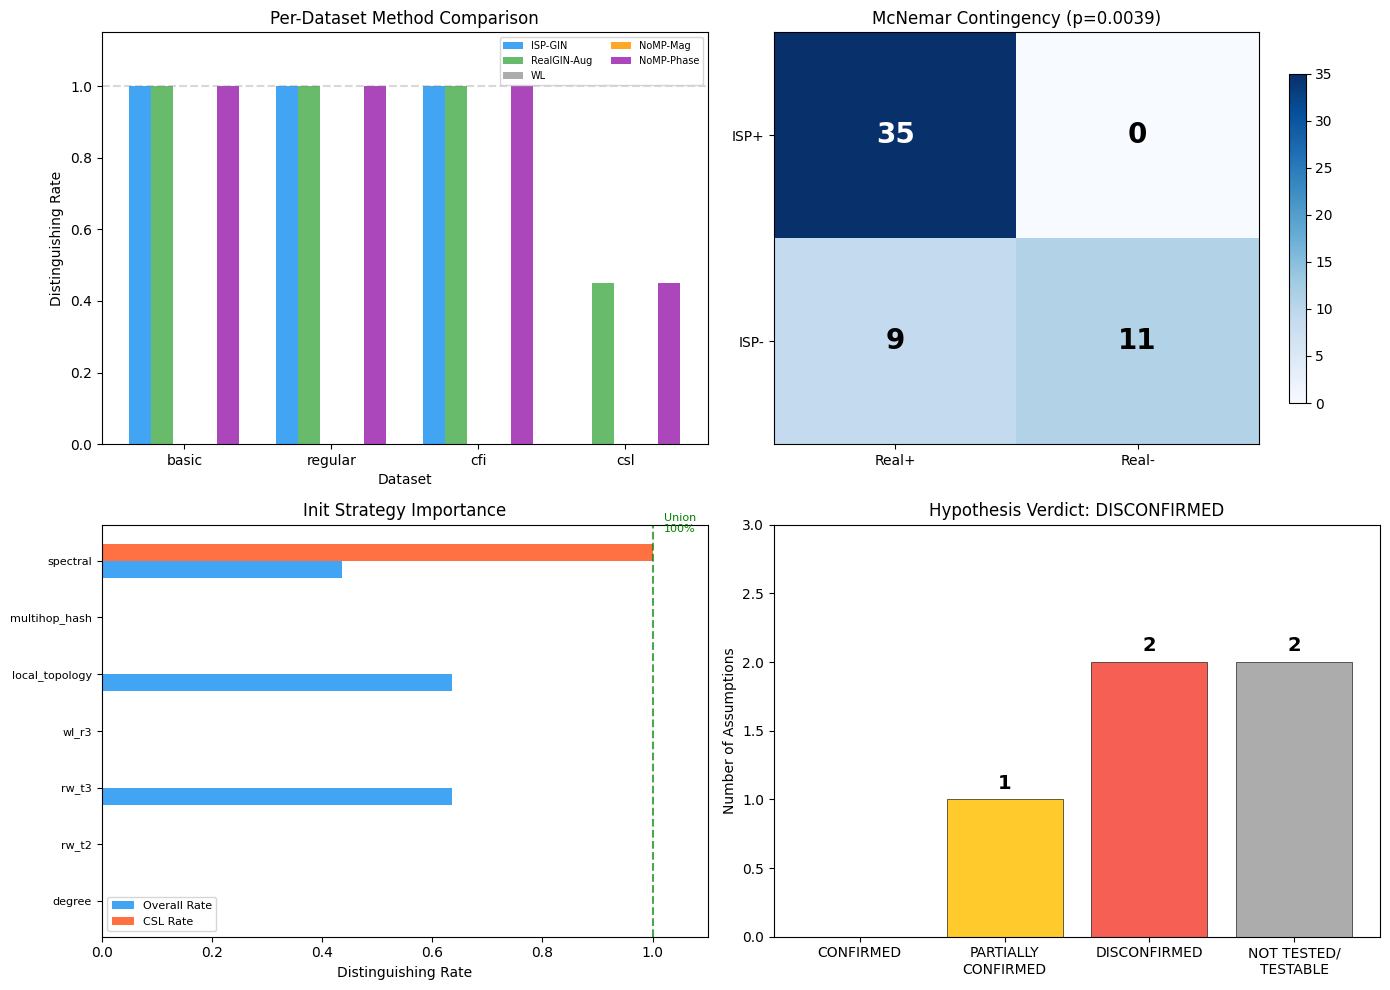

Figure saved to evaluation_summary.png


In [13]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- Panel 1: Per-Dataset Method Comparison (grouped bar chart) ---
ax1 = axes[0, 0]
ds_names = DATASET_ORDER
x = np.arange(len(ds_names))
width = 0.15
methods = ["ISP-GIN", "RealGIN-Aug", "WL", "NoMP-Mag", "NoMP-Phase"]
colors = ["#2196F3", "#4CAF50", "#9E9E9E", "#FF9800", "#9C27B0"]

for i, (method, color) in enumerate(zip(methods, colors)):
    rates = []
    for ds in ds_names:
        ds_info = per_dataset_results[ds]
        if method == "ISP-GIN":
            rates.append(ds_info["isp_rate"])
        elif method == "RealGIN-Aug":
            rates.append(ds_info["real_rate"])
        elif method == "WL":
            rates.append(ds_info["wl_rate"])
        elif method == "NoMP-Mag":
            rates.append(ds_info["nomp_mag_rate"])
        elif method == "NoMP-Phase":
            rates.append(ds_info["nomp_phase_rate"])
    ax1.bar(x + i * width, rates, width, label=method, color=color, alpha=0.85)

ax1.set_xlabel("Dataset")
ax1.set_ylabel("Distinguishing Rate")
ax1.set_title("Per-Dataset Method Comparison")
ax1.set_xticks(x + 2 * width)
ax1.set_xticklabels([d.replace("brec_", "") for d in ds_names])
ax1.set_ylim(0, 1.15)
ax1.legend(fontsize=7, ncol=2)
ax1.axhline(y=1.0, color="gray", linestyle="--", alpha=0.3)

# --- Panel 2: McNemar Contingency Table (heatmap) ---
ax2 = axes[0, 1]
contingency = np.array([[a, b], [c, d]])
im = ax2.imshow(contingency, cmap="Blues", aspect="auto")
ax2.set_xticks([0, 1])
ax2.set_yticks([0, 1])
ax2.set_xticklabels(["Real+", "Real-"])
ax2.set_yticklabels(["ISP+", "ISP-"])
for i in range(2):
    for j in range(2):
        ax2.text(j, i, str(contingency[i, j]),
                 ha="center", va="center", fontsize=20, fontweight="bold",
                 color="white" if contingency[i, j] > 15 else "black")
ax2.set_title(f"McNemar Contingency (p={mcnemar_pvalue:.4f})")
fig.colorbar(im, ax=ax2, shrink=0.8)

# --- Panel 3: Init Strategy Importance ---
ax3 = axes[1, 0]
init_names = ITER2_INIT_STRATEGIES
init_rates = [metrics.get(f"init_rate_{init.replace('-','_')}", 0.0) for init in init_names]
init_csl = [metrics.get(f"init_csl_{init.replace('-','_')}", 0.0) for init in init_names]

x3 = np.arange(len(init_names))
ax3.barh(x3 - 0.15, init_rates, 0.3, label="Overall Rate", color="#2196F3", alpha=0.85)
ax3.barh(x3 + 0.15, init_csl, 0.3, label="CSL Rate", color="#FF5722", alpha=0.85)
ax3.set_yticks(x3)
ax3.set_yticklabels([n.replace("random_walk_", "rw_").replace("wl_color_", "wl_")
                     for n in init_names], fontsize=8)
ax3.set_xlabel("Distinguishing Rate")
ax3.set_title("Init Strategy Importance")
ax3.legend(fontsize=8)
ax3.set_xlim(0, 1.1)
# Mark union rate
ax3.axvline(x=union_rate, color="green", linestyle="--", alpha=0.7, label=f"Union={union_rate:.0%}")
ax3.text(union_rate + 0.02, len(init_names) - 0.5, f"Union\n{union_rate:.0%}",
         fontsize=8, color="green")

# --- Panel 4: Hypothesis Verdict Summary ---
ax4 = axes[1, 1]
verdict_labels = ["CONFIRMED", "PARTIALLY\nCONFIRMED", "DISCONFIRMED", "NOT TESTED/\nTESTABLE"]
verdict_counts = [n_confirmed, n_partial, n_disconfirmed, n_other]
verdict_colors = ["#4CAF50", "#FFC107", "#F44336", "#9E9E9E"]
bars = ax4.bar(verdict_labels, verdict_counts, color=verdict_colors, alpha=0.85, edgecolor="black", linewidth=0.5)
for bar, count in zip(bars, verdict_counts):
    if count > 0:
        ax4.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05,
                 str(count), ha="center", va="bottom", fontsize=14, fontweight="bold")
ax4.set_ylabel("Number of Assumptions")
ax4.set_title(f"Hypothesis Verdict: {metadata.get('overall_hypothesis_verdict', 'N/A')}")
ax4.set_ylim(0, max(verdict_counts) + 1)

plt.tight_layout()
plt.savefig("evaluation_summary.png", dpi=150, bbox_inches="tight")
plt.show()
print("Figure saved to evaluation_summary.png")